In [4]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
import re                                  
import string                              
from nltk.corpus import stopwords          
from nltk.stem import PorterStemmer        
from nltk.tokenize import TweetTokenizer 
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pozir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def prepro_tweet(text):
    '''
    A function that does tokenizing, lowercasing, removing stop words and 
    punctuation and stems a string.
    '''
    stopwords_english = stopwords.words('english')
    stemmer = PorterStemmer() 

    # remove stock market tickers like $GE and old style retweet text "RT"  
    string2 = re.sub(r'\$\w*', '', text)
    string2 = re.sub(r'^RT[\s]+', '', string2)

    # remove hyperlinks
    string2 = re.sub(r'https?:\/\/.*[\r\n]*', '', string2)

    # remove # sign
    string2 = re.sub(r'#', '', string2)

    # instantiate tokenizer class
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                                   reduce_len=True)

    # tokenize tweets
    string_tokens = tokenizer.tokenize(string2)

    string_clean = []

    # remove stop words and punctuation
    for word in string_tokens:
        if (word not in stopwords_english and
            word not in string.punctuation):
            string_clean.append(word)

    # stemming the tokens
    string_stem = []

    for word in string_clean:
        stem_word = stemmer.stem(word) 
        string_stem.append(stem_word) 

    return string_stem

In [13]:
def count_dict(texts, labels):
    """count_dict.
    Input:
    texts: a list of tweets
    labels: an m x 1 array with the sentiment label of each tweet
    (either 0 or 1)
    Output:
    freqs: a dictionary mapping each (word, sentiment) pair to its
    frequency
    """
    labels = np.squeeze(labels).tolist()
    freq_dict = {}
    for tweet, y in zip(texts, labels):
        for w in prepro_tweet(tweet):
            k = (w, y)
            if k in freq_dict:
                freq_dict[k] += 1
            else:
                freq_dict[k] = 1

    return freq_dict     

In [2]:
def visual_class(labels, sizes):
    '''
    A function that visualizes the proportion of the predicted classes;
    labels: a list of the class names
    sizes: a list ofclasses counts
    '''
    # Declare a figure with a custom size
    fig = plt.figure(figsize=(5, 5))

    # Declare pie chart, where the slices will be ordered and plotted counter-clockwise:
    plt.pie(sizes, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)

    # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.axis('equal')
    # Display the chart
    plt.show()

In [1]:
def visual_words(list_of_words, dict_freq):
    '''
    A function that visualizes how often given words apper in positive and negative 
    tweets. The plot is in the logarithmic scale to take into account the wide 
    discrepancies between the raw counts. The red line marks the boundary between 
    positive and negative areas. Words close to the red line can be classified as 
    neutral.
    list_of_words: the list of the preprocessed words from the tweets;
    dict_freq: a dictionary of the word frequencies per each class;
    '''
    pos = 0
    neg = 0
    data = []
    
    for word in list_of_words:
        if (word, 1.0) in dict_freq:
            pos = dict_freq[(word, 1.0)]
        if (word, 0.0) in dict_freq:
            neg = dict_freq[(word, 0.0)]
        data.append([word, pos, neg])
        
    fig, ax = plt.subplots(figsize = (8, 8))

    # convert positive raw counts to logarithmic scale. we add 1 to avoid log(0)
    x = np.log([x[1] + 1 for x in data])  

    # do the same for the negative counts
    y = np.log([x[2] + 1 for x in data]) 

    # Plot a dot for each pair of words
    ax.scatter(x, y)  

    # assign axis labels
    plt.xlabel("Log Positive count")
    plt.ylabel("Log Negative count")

    # Add the word as the label at the same position as you added the points just before
    for i in range(0, len(data)):
        ax.annotate(data[i][0], (x[i], y[i]), fontsize=12)

    ax.plot([0, 9], [0, 9], color = 'red') # Plot the red line that divides the 2 areas.
    plt.show()

    return 

In [ ]:
def sigmoid(z): 
    '''
    Input:
        z: is the input (can be a scalar or an array)
    Output:
        h: the sigmoid of z
    '''      
    h = 1/(1+ 2.718281828459045**(-z))
    
    return h

In [1]:
def extract_features(tweet, freqs):
    '''
    This function takes in a single tweet, processes it using the imported prepro_tweet() function and 
    saves the list of tweet words, loop through each word in the list of processed words and for each 
    word, check the frequency dictionary for the count when that word has a positive '1' label.
    Input: 
        tweet: a list of words for one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output: 
        x: a feature vector of dimension (1,3)
    '''
    # process_tweet tokenizes, stems, and removes stopwords
    word_l = prepro_tweet(tweet)
    
    # 3 elements in the form of a 1 x 3 vector
    x = np.zeros((1, 3)) 
    
    #bias term is set to 1
    x[0,0] = 1 
    
    # loop through each word in the list of words
    for word in word_l:
        
        # increment the word count for the positive label 1
        x[0,1] += freqs.get((word, 1.0), 0)
        
        # increment the word count for the negative label 0
        x[0,2] += freqs.get((word, 0.0), 0)
        
    assert(x.shape == (1, 3))
    return x

In [ ]:
def gradientDescent(x, y, theta, alpha, num_iters):
    '''
    Input:
        x: matrix of features which is (m,n+1)
        y: corresponding labels of the input matrix x, dimensions (m,1)
        theta: weight vector of dimension (n+1,1)
        alpha: learning rate
        num_iters: number of iterations you want to train your model for
    Output:
        J: the final cost
        theta: your final weight vector
    '''
    m = len(x)
    iter_times = []
    costs = []
    for i in range(0, num_iters):
        
        iter_times.append(i)
        # get z, the dot product of x and theta
        z = x.dot(theta)
        
        # get the sigmoid of z
        h = sigmoid(z)
        
        # calculate the cost function
        J = (-1/m)*((y.T.dot(np.log(h)))+((1-y).T.dot(np.log(1-h))))
        #print(type(J))
        #print(J)
        costs.append(J[0][0])
        
        # update the weights theta
        theta = theta-alpha/m*(x.T.dot(h - y))
    plt.plot(iter_times, costs)
    plt.show()    
    J = float(J)
    return J, theta

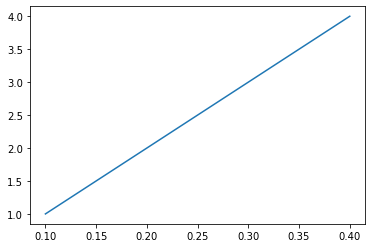

In [5]:
plt.plot([0.1, 0.2, 0.3, 0.4], [1, 2, 3, 4])

In [ ]:
def predict_tweet(tweet, freqs, theta):
    '''
    Given a tweet the function processes it, extracts the features, applies the model's learned weights on 
    the features to get the logits, applies the sigmoid to the logits to get the prediction
    (a value between 0 and 1). 𝑦𝑝𝑟𝑒𝑑=𝑠𝑖𝑔𝑚𝑜𝑖𝑑(𝐱⋅𝜃)
    Input: 
        tweet: a string
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
        theta: (3,1) vector of weights
    Output: 
        y_pred: the probability of a tweet being positive or negative
    '''
    
    # extract the features of the tweet and store it into x
    x = extract_features(tweet, freqs)
    
    # make the prediction using x and theta
    y_pred = sigmoid(x.dot(theta))
    
    return y_pred

In [ ]:
def accuracy_score(test_x, test_y, freqs, theta):
    """
    Input: 
        test_x: a list of tweets
        test_y: (m, 1) vector with the corresponding labels for the list of tweets
        freqs: a dictionary with the frequency of each pair (or tuple)
        theta: weight vector of dimension (3, 1)
    Output: 
        accuracy: (# of tweets classified correctly) / (total # of tweets)
    """   
    # the list for storing predictions
    y_hat = []
    
    for tweet in test_x:
        # get the label prediction for the tweet
        y_pred = predict_tweet(tweet, freqs, theta)
        
        if y_pred > 0.5:
            # append 1.0 to the list
            y_hat.append(1.0)
        else:
            # append 0 to the list
            y_hat.append(0.0)
            
    y_hat = np.array(y_hat)
    y_hat.resize((len(y_hat), 1))
    accuracy = ((y_hat == test_y).sum())/len(test_y)
    
    return accuracy

In [ ]:
def single_pred(text, freqs, theta):
    print(prepro_tweet(text))
    y_hat = predict_tweet(text, freqs, theta)
    print(y_hat)
    if y_hat > 0.5:
        print('Positive sentiment')
    else:
        print('Negative sentiment')

In [ ]:
def misClass(test_x, test_y, freqs, theta):
    '''
    Function that returns the tweets that were misclassified.
    '''
    print('Label Predicted Tweet')
    for x,y in zip(test_x,test_y):
        y_hat = predict_tweet(x, freqs, theta)
            
        if np.abs(y - (y_hat > 0.5)) > 0:
            print('THE TWEET IS:', x)
            print('THE PROCESSED TWEET IS:', prepro_tweet(x))
            print('%d\t%0.8f\t%s' % (y, y_hat, ' '.join(prepro_tweet(x)).encode('ascii', 'ignore')))
            print('********************************************************************************')